In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [94]:
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [95]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression

temp_df = all_df.copy()

fare_inlier = temp_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna())]
fare_outlier = temp_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna())]

transformer = PowerTransformer()

X_train = fare_inlier[['Pclass', 'SibSp', 'Parch']]
X_test = fare_outlier[['Pclass', 'SibSp', 'Parch']]
y_train = transformer.fit_transform(fare_inlier.Fare.values.reshape(-1,1))

fare_model = LinearRegression()
fare_model.fit(X_train, y_train)

y_pred = fare_model.predict(X_test)

all_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna()), 'Fare'] = y_train
all_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna()), 'Fare'] = y_pred

In [96]:
from sklearn.preprocessing import OneHotEncoder

sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(all_df[['Sex']])
sex_df = pd.DataFrame(sex_encoded, columns=sex_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, sex_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-1.215092,NaN,S,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.370847,C85,C,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.183866,C123,S,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-1.025820,NaN,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,-1.025820,NaN,S,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,1.591007,C105,C,1,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,-1.215092,NaN,S,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,-1.025820,NaN,S,0,1


0.8053435114503816
['C' 'C']


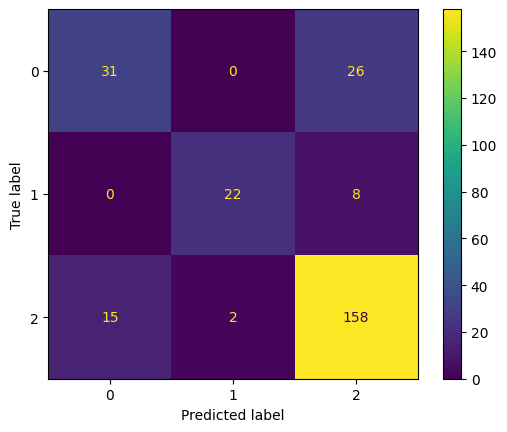

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

embark_df = all_df[~all_df['Embarked'].isna()]

X_names = [*sex_encoder.get_feature_names_out(), 'Pclass', 'SibSp', 'Parch', 'Fare']
X = embark_df[X_names]
y = np.array(embark_df['Embarked'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

embark_model = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1)
embark_model.fit(X_train, y_train)
y_pred = embark_model.predict(X_test)
print(embark_model.score(X_test, y_test))
matrix = metrics.confusion_matrix(y_test, y_pred)
display = metrics.ConfusionMatrixDisplay(matrix)
display.plot()

missing_embark = all_df[all_df['Embarked'].isna()]

embark_model.fit(X, y)
X_missing = missing_embark[X_names]
y_missing = embark_model.predict(X_missing)
print(y_missing)

In [98]:
all_df['Embarked'] = all_df['Embarked'].fillna('C')

In [99]:
embarked_encoder = OneHotEncoder(sparse_output=False)
embarked_encoded = embarked_encoder.fit_transform(all_df[['Embarked']])
embarked_df = pd.DataFrame(embarked_encoded, columns=embarked_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, embarked_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-1.215092,NaN,S,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.370847,C85,C,1,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.183866,C123,S,1,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-1.025820,NaN,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,-1.025820,NaN,S,0,1,0,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,1.591007,C105,C,1,0,1,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,-1.215092,NaN,S,0,1,0,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,-1.025820,NaN,S,0,1,0,0,1


In [106]:
from sklearn.ensemble import RandomForestRegressor

temp_df = all_df.copy()

age_inliers = all_df[~all_df['Age'].isna()]
age_outliers = all_df[all_df['Age'].isna()]

X_train = age_inliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
X_test = age_outliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
y_train = age_inliers['Age'].values

age_model = RandomForestRegressor()
age_model.fit(X_train, y_train)

y_pred = age_model.predict(X_test)

all_df.loc[all_df['Age'].isna(), 'Age'] = y_pred

In [111]:
train_df = all_df.iloc[:891]
test_df = all_df.iloc[891:].reset_index(drop=True)

In [112]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,-1.215092,NaN,S,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,1.370847,C85,C,1,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,1.183866,C123,S,1,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,-1.025820,NaN,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,-0.259146,NaN,S,0,1,0,0,1
887,888,1.0,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,0.722418,B42,S,1,0,0,0,1
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.606259,1,2,W./C. 6607,0.475343,NaN,S,1,0,0,0,1
889,890,1.0,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,0.722418,C148,C,0,1,1,0,0


In [131]:
from sklearn.linear_model import LogisticRegression

X = train_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = train_df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.8268156424581006